In [79]:
import pandas as pd
import os
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact
import plotly.graph_objects as go
import ruptures as rpt
from itertools import combinations as comb
from statsmodels.stats import power
import numpy as np

from IPython.display import display
# pd.set_option('display.max_rows', 50)

In [3]:
cpd_model = rpt.Binseg(model = 'l2',jump=500, min_size=4500)
def change_point_detection(df, throw_away = 0.1):
    """
    Changepoint Detection
    Input: - df:  from read_data
           - key: which is the filename
           - throw_away: everything smaller than 10% of the total length of data is thrown away

    Returns: - return_dict: A dictionary with all the data and the format key_cnt
    """
    signal = df[['accelerometer_x','accelerometer_y','accelerometer_z']].values
    length = len(df)
    algo = cpd_model.fit(signal)
    result = [0]
    result += algo.predict(pen=1000)
    if result[-1] != length:
        result += [length]
        
    return_df = pd.DataFrame()
    for i in range(len(result)-1):
        if result[i+1]-result[i] > length*throw_away:
            if return_df.empty:
                return_df = df.iloc[result[i]:result[i+1]]
            else:
                pd.concat([return_df, df.iloc[result[i]:result[i+1]]],ignore_index=True)
            
    """
    This is the seperated version, so we dont have windows that belong to different changepoint sections
    return_dict = {}
    cnt = 1
    for i in range(len(result)-1):
        if result[i+1]-result[i] > length*throw_away:
            return_dict[key+'_'+str(cnt)] = df.iloc[result[i]:result[i+1]]
            cnt+=1
    """
    return return_df

In [7]:
folder_path = '../data'
def read_data(filename):
    accelerometer = pd.read_csv(os.path.join(folder_path, filename, 'Accelerometer.csv'),sep=';')
    accelerometer['Time (s)'] = pd.to_datetime(accelerometer['Time (s)'], unit='s')
    accelerometer = accelerometer.set_index('Time (s)')
    accelerometer = accelerometer.resample('2.5ms').mean()
    accelerometer.rename(columns={'Acceleration x (m/s^2)':'accelerometer_x','Acceleration y (m/s^2)':'accelerometer_y','Acceleration z (m/s^2)':'accelerometer_z'}, inplace=True)
    #accelerometer =accelerometer[9000:-9000]
    accelerometer.reset_index(inplace=True)

    gyroscope = pd.read_csv(os.path.join(folder_path, filename,'Gyroscope.csv'),sep=';')
    gyroscope['Time (s)'] = pd.to_datetime(gyroscope['Time (s)'], unit='s')
    gyroscope =gyroscope.set_index('Time (s)')
    gyroscope = gyroscope.resample('2.5ms').mean()
    gyroscope.rename(columns={'Gyroscope x (rad/s)':'gyroscope_x','Gyroscope y (rad/s)':'gyroscope_y','Gyroscope z (rad/s)':'gyroscope_z'}, inplace=True)
    #gyroscope = gyroscope[9000:-9000]
    gyroscope.reset_index(inplace=True)
    merged = pd.merge(accelerometer,gyroscope, on= 'Time (s)', how='inner')
    return change_point_detection(merged)

In [5]:
# regex to delete the number at the end of the string:
def delete_number(string):
    return ''.join([i for i in string if not i.isdigit()])

In [8]:
data_dict = {}
name_to_idx = {} # name -> idx
i = 0

for name in os.listdir(folder_path):
    data_dict[name] = read_data(name)
    data_dict[name].drop(columns=['Time (s)'], inplace=True)
    # add label
    if delete_number(name) not in name_to_idx.keys():
        name_to_idx[delete_number(name)] = i
        i+=1

In [37]:
# Function to get the base name
def get_base_name(key):
    for i in range(len(key)-1, -1, -1):
        if key[i].isdigit():
            continue
        return key[:i+1]
        
# Group dataframes by base name
grouped_dict = {}
for key, df in data_dict.items():
    base_name = get_base_name(key)
    if base_name not in grouped_dict:
        grouped_dict[base_name] = []
    grouped_dict[base_name].append(df)

In [58]:
# Function to calculate mean and variance over windowed segments
def window_mean_var(df, window_size=2050):
    df = df.reset_index(drop=True)
    windows = [df.iloc[i:i + window_size] for i in range(0, len(df), window_size)]
    result = []
    for window in windows:
        if len(window) < window_size:
            continue
        mean_vals = window.mean()
        var_vals = window.var()
        combined = {f"{col}_mean": mean_vals[col] for col in mean_vals.index}
        combined.update({f"{col}_var": var_vals[col] for col in var_vals.index})
        result.append(combined)
    return pd.DataFrame(result)


# Process each grouped dataframe and concatenate
processed_dict = {}
for base_name, dfs in grouped_dict.items():
    concatenated_df = pd.concat(dfs).reset_index(drop=True)
    processed_df = window_mean_var(concatenated_df)
    processed_dict[base_name] = processed_df

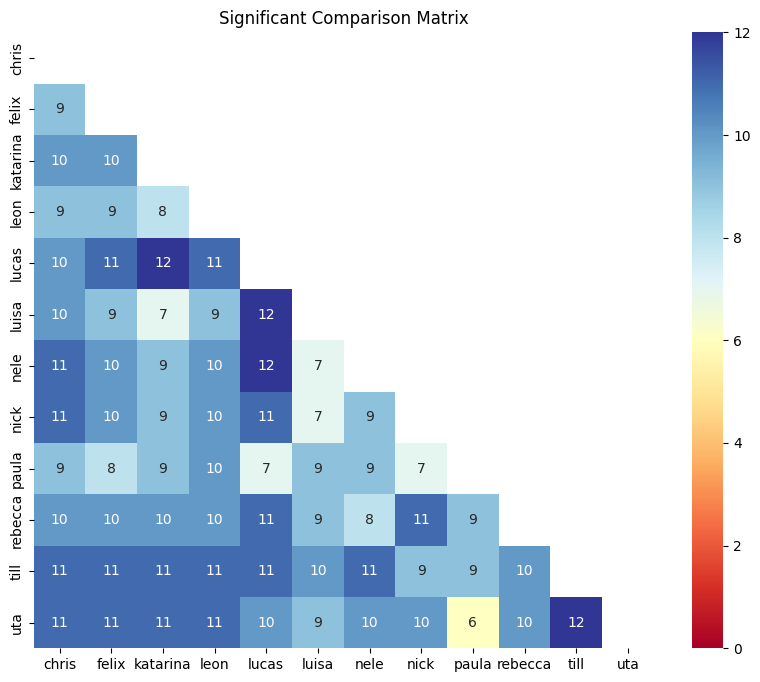

In [86]:
# Significance level
significance_level = 0.05 / 12

# Get all the unique base names
base_names = list(processed_dict.keys())

# Initialize a matrix to store the counts of significant comparisons
significant_matrix = pd.DataFrame(0, index=base_names, columns=base_names, dtype=float)

# Perform the Mann-Whitney U test for each pair of dataframes
for i in range(len(base_names)):
    for j in range(i + 1, len(base_names)):
        name1 = base_names[i]
        name2 = base_names[j]
        df1 = processed_dict[name1]
        df2 = processed_dict[name2]
        
        # Ensure both dataframes have the same columns
        common_columns = df1.columns.intersection(df2.columns)
        
        count_significant = 0
        for column in common_columns:
            # Perform the Mann-Whitney U test
            u_stat, p_val = stats.mannwhitneyu(df1[column], df2[column], alternative='two-sided')
            # Check if p-value is less than the significance level
            if p_val < significance_level:
                count_significant += 1
        
        # Fill the matrix with the count of significant comparisons
        significant_matrix.at[name1, name2] = count_significant
        significant_matrix.at[name2, name1] = count_significant
np.fill_diagonal(significant_matrix.values, np.nan)
mask = np.triu(np.ones_like(significant_matrix, dtype=bool))

# Plot the significant comparison matrix with color coding
plt.figure(figsize=(10, 8))
sns.heatmap(significant_matrix, annot=True, cmap='RdYlBu', cbar=True, vmin=0, vmax=12, mask=mask)
plt.title('Significant Comparison Matrix')
plt.show()

In [19]:
folder_path = 'data'
def calculate_mean_for_30s(df):
    df['Time (s)'] = pd.to_datetime(df['Time (s)'], unit='s')
    df.set_index('Time (s)', inplace=True)
    resampled_df = df.resample('30s').mean()
    return resampled_df

def calculate_var_for_30s(df):
    resampled_df = df.resample('30s').var()
    return resampled_df

def read_data(filename):
    accelerometer = pd.read_csv(os.path.join(folder_path, filename, 'Accelerometer.csv'),sep=';')
    gyroscope = pd.read_csv(os.path.join(folder_path, filename,'Gyroscope.csv'),sep=';')
    accelerometer.rename(columns={'Acceleration x (m/s^2)':'accelerometer_x','Acceleration y (m/s^2)':'accelerometer_y','Acceleration z (m/s^2)':'accelerometer_z'}, inplace=True)
    gyroscope.rename(columns={'Gyroscope x (rad/s)':'gyroscope_x','Gyroscope y (rad/s)':'gyroscope_y','Gyroscope z (rad/s)':'gyroscope_z'}, inplace=True)
    accelerometer =accelerometer[9000:-9000]
    gyroscope = gyroscope[9000:-9000]
    accelerometer_mean = calculate_mean_for_30s(accelerometer)
    gyroscope_mean = calculate_mean_for_30s(gyroscope)
    accelerometer_var = calculate_var_for_30s(accelerometer)
    gyroscope_var = calculate_var_for_30s(gyroscope)
    return accelerometer, gyroscope , accelerometer_mean, gyroscope_mean, accelerometer_var, gyroscope_var

def do_test(dataframe1, dataframe2):
    t_stat, p_val = stats.ttest_ind(dataframe1, dataframe2)
    return t_stat, p_val

In [20]:
accelerometer_lucas1, gyroscope_lucas1, accelerometer_lucas1_mean, gyroscope_lucas1_mean, accelerometer_lucas1_var, gyroscope_lucas1_var  = read_data('lucas1')
accelerometer_nick1, gyroscope_nick1, accelerometer_nick1_mean, gyroscope_nick1_mean, accelerometer_nick1_var, gyroscope_nick1_var  = read_data('nick1')
accelerometer_till1, gyroscope_till1, accelerometer_till1_mean, gyroscope_till1_mean, accelerometer_till1_var, gyroscope_till1_var  = read_data('till1')
accelerometer_luisa1, gyroscope_luisa1, accelerometer_luisa1_mean, gyroscope_luisa1_mean, accelerometer_luisa1_var, gyroscope_luisa1_var  = read_data('luisa1')

In [21]:
len(accelerometer_lucas1)

163009

In [46]:
len(accelerometer_nick1), len(gyroscope_nick1)

(395356, 395300)

In [42]:
10_000 * 14.35 / len(accelerometer_nick1)

0.3629640121814264

In [10]:
dict_accel_var = {'accelerometer_lucas1_var': accelerometer_lucas1_var, 'accelerometer_nick1_var': accelerometer_nick1_var, 'accelerometer_till1_var': accelerometer_till1_var, 'accelerometer_luisa1_var': accelerometer_luisa1_var}
dict_accel_mean = {'accelerometer_lucas1_mean': accelerometer_lucas1_mean, 'accelerometer_nick1_mean': accelerometer_nick1_mean, 'accelerometer_till1_mean': accelerometer_till1_mean, 'accelerometer_luisa1_mean': accelerometer_luisa1_mean}
dict_gyro_var = {'gyroscope_lucas1_var': gyroscope_lucas1_var, 'gyroscope_nick1_var': gyroscope_nick1_var, 'gyroscope_till1_var': gyroscope_till1_var, 'gyroscope_luisa1_var': gyroscope_luisa1_var}
dict_gyro_mean = {'gyroscope_lucas1_mean': gyroscope_lucas1_mean, 'gyroscope_nick1_mean': gyroscope_nick1_mean, 'gyroscope_till1_mean': gyroscope_till1_mean, 'gyroscope_luisa1_mean': gyroscope_luisa1_mean}
dict_of_dfs = {'accel_mean': dict_accel_mean, 'gyro_mean':dict_gyro_mean,'accel_var':dict_accel_var, 'gyro_var' :dict_gyro_var}

In [66]:
list_columns_accelerometer = ['accelerometer_x', 'accelerometer_y', 'accelerometer_z']
list_columns_gyroscope = ['gyroscope_x', 'gyroscope_y', 'gyroscope_z']

# die art wie ich hier die results speichere suckt, sollte eigentlich nen table als index haben aber we
results = {}

search_string = 'accelerometer'
t = power.TTestPower()

for df_name, df in dict_of_dfs.items():
    combinations = list(comb(df, 2))
    for combo in combinations:
        if search_string in combo[0]:
            for column in list_columns_accelerometer:
                effect_size =  (df[combo[0]][column].mean()-df[combo[1]][column].mean())/pd.concat([df[combo[0]][column], df[combo[1]][column]]).std()
                nr_participants = t.solve_power(effect_size=effect_size, nobs=None, alpha=0.05, power=0.90, alternative='two-sided')
                t_stat, p_val = do_test(df[combo[0]][column], df[combo[1]][column])
                results[(combo[0],combo[1],column)] = [t_stat, p_val, nr_participants]
        else:
            for column in list_columns_gyroscope:
                t_stat, p_val = do_test(df[combo[0]][column], df[combo[1]][column])
                effect_size =  (df[combo[0]][column].mean()-df[combo[1]][column].mean())/pd.concat([df[combo[0]][column], df[combo[1]][column]]).std()
                nr_participants = t.solve_power(effect_size=effect_size, nobs=None, alpha=0.05, power=0.90, alternative='two-sided')
                results[(combo[0],combo[1],column)] = [t_stat, p_val, nr_participants]

results_df = pd.DataFrame.from_dict(results, orient='index', columns=['T_Statistic', 'P_Value', 'samples_required'])
results_df['minutes_required'] = results_df['samples_required']/2

In [67]:
pd.set_option('display.float_format', '{:.4f}'.format)
results_df[:36]

,T_Statistic,P_Value,samples_required,minutes_required
"(accelerometer_lucas1_mean, accelerometer_nick1_mean, accelerometer_x)",47.3376,0.0000,4.7286,2.3643
"(accelerometer_lucas1_mean, accelerometer_nick1_mean, accelerometer_y)",-2.9718,0.0048,16.0592,8.0296
"(accelerometer_lucas1_mean, accelerometer_nick1_mean, accelerometer_z)",10.5200,0.0000,5.5695,2.7848
"(accelerometer_lucas1_mean, accelerometer_till1_mean, accelerometer_x)",45.9698,0.0000,4.8841,2.4420
"(accelerometer_lucas1_mean, accelerometer_till1_mean, accelerometer_y)",-8.3831,0.0000,6.1252,3.0626
"(accelerometer_lucas1_mean, accelerometer_till1_mean, accelerometer_z)",34.2570,0.0000,4.9182,2.4591
"(accelerometer_lucas1_mean, accelerometer_luisa1_mean, accelerometer_x)",22.2285,0.0000,5.0451,2.5225
"(accelerometer_lucas1_mean, accelerometer_luisa1_mean, accelerometer_y)",-11.9592,0.0000,5.4849,2.7424
"(accelerometer_lucas1_mean, accelerometer_luisa1_mean, accelerometer_z)",63.3717,0.0000,4.8882,2.4441
"(accelerometer_nick1_mean, accelerometer_till1_mean, accelerometer_x)",-21.7040,0.0000,5.2062,2.6031


In [22]:
pd.set_option('display.float_format', '{:.4f}'.format)
display(results_df)

,T Statistic,P Value
"(accelerometer_lucas1_var, accelerometer_nick1_var, accelerometer_x)",47.7645,0.0000
"(accelerometer_lucas1_var, accelerometer_nick1_var, accelerometer_y)",6.9340,0.0000
"(accelerometer_lucas1_var, accelerometer_nick1_var, accelerometer_z)",-13.2708,0.0000
"(accelerometer_lucas1_var, accelerometer_till1_var, accelerometer_x)",51.8719,0.0000
"(accelerometer_lucas1_var, accelerometer_till1_var, accelerometer_y)",16.5029,0.0000
"(accelerometer_lucas1_var, accelerometer_till1_var, accelerometer_z)",-8.3623,0.0000
"(accelerometer_lucas1_var, accelerometer_luisa1_var, accelerometer_x)",29.1915,0.0000
"(accelerometer_lucas1_var, accelerometer_luisa1_var, accelerometer_y)",21.0872,0.0000
"(accelerometer_lucas1_var, accelerometer_luisa1_var, accelerometer_z)",12.6887,0.0000
"(accelerometer_nick1_var, accelerometer_till1_var, accelerometer_x)",12.3039,0.0000


In [19]:
t = power.TTestPower()

In [20]:
t.solve_power(effect_size=0.865871, nobs=None, alpha=0.05, power=0.99, alternative='two-sided')

26.52651185356142

In [60]:
4*3*4

48

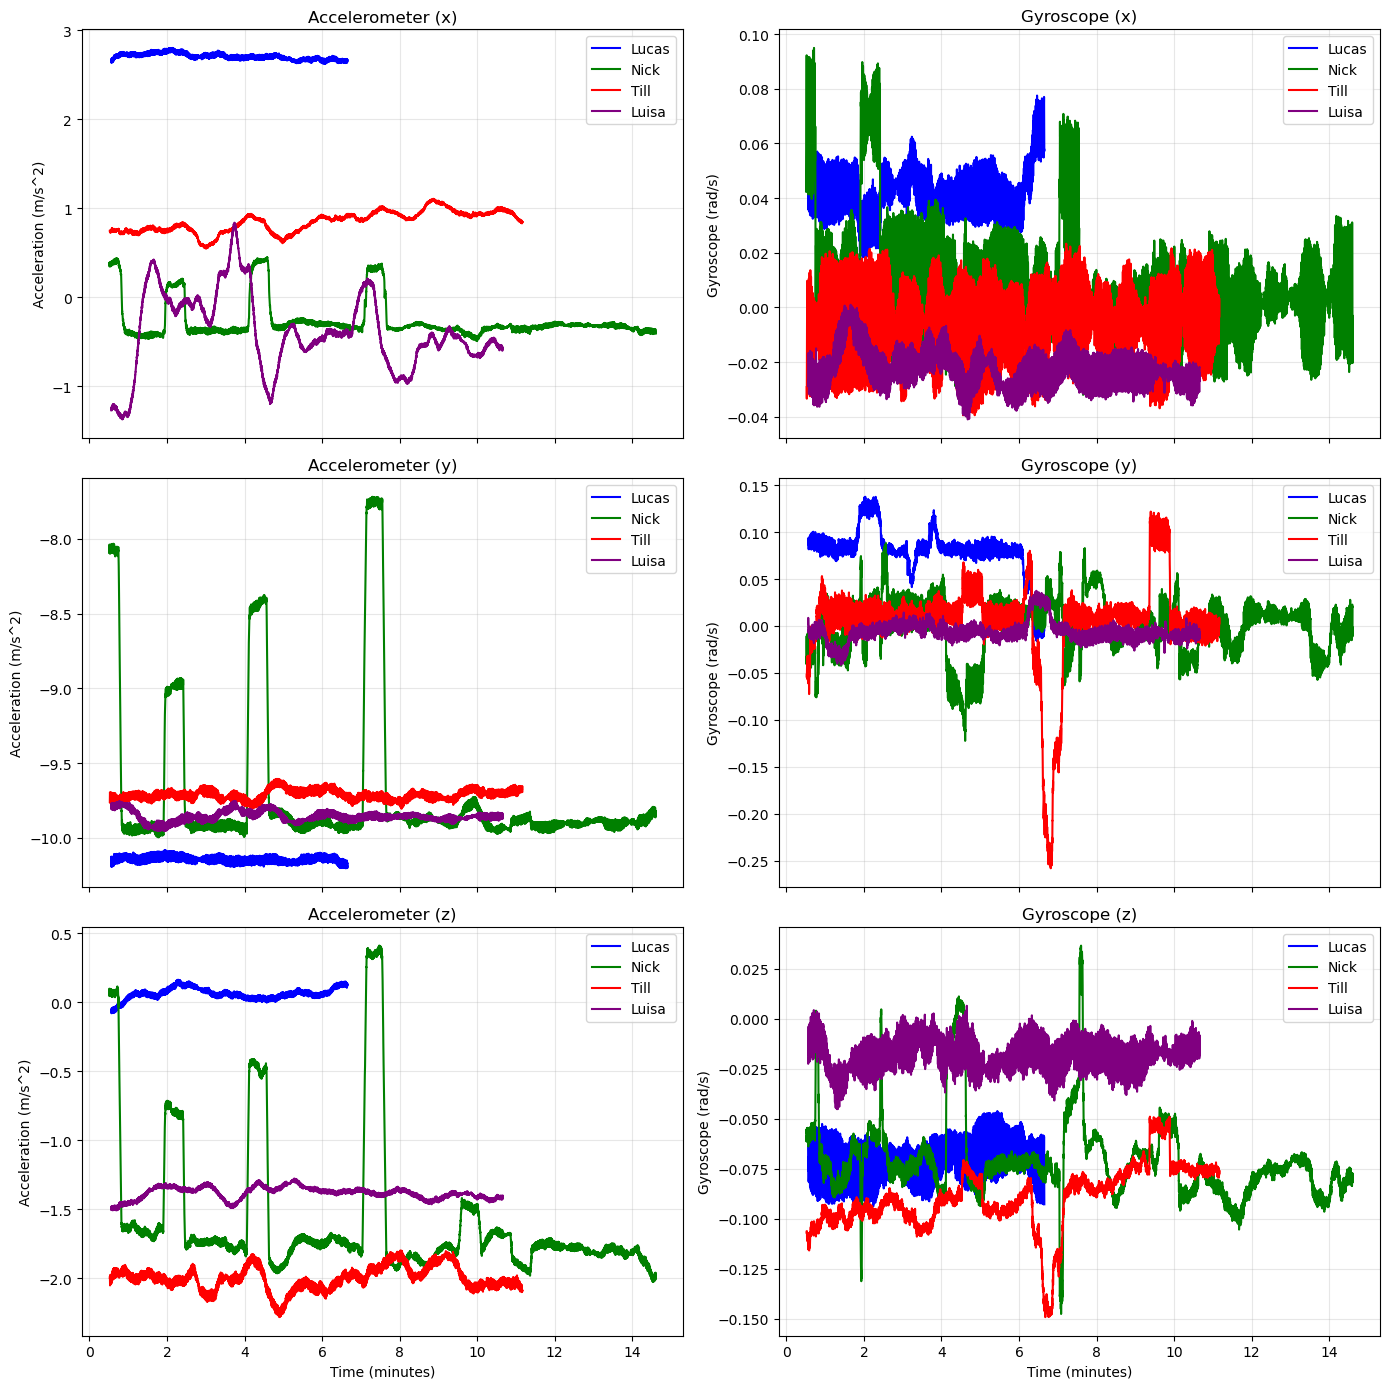

In [47]:
import matplotlib.pyplot as plt
import pandas as pd
import os

# Folder path where data is stored
folder_path = 'data'

# Function to calculate the mean for 30s intervals
def calculate_mean_for_30s(df):
    df['Time (s)'] = pd.to_datetime(df['Time (s)'], unit='s')
    df.set_index('Time (s)', inplace=True)
    resampled_df = df.resample('30s').mean()
    return resampled_df

# Function to calculate the variance for 30s intervals
def calculate_var_for_30s(df):
    resampled_df = df.resample('30s').var()
    return resampled_df

# Function to read data from CSV files
def read_data(filename):
    accelerometer = pd.read_csv(os.path.join(folder_path, filename, 'Accelerometer.csv'), sep=';')
    gyroscope = pd.read_csv(os.path.join(folder_path, filename, 'Gyroscope.csv'), sep=';')
    accelerometer.rename(columns={'Acceleration x (m/s^2)': 'accelerometer_x', 'Acceleration y (m/s^2)': 'accelerometer_y', 'Acceleration z (m/s^2)': 'accelerometer_z'}, inplace=True)
    gyroscope.rename(columns={'Gyroscope x (rad/s)': 'gyroscope_x', 'Gyroscope y (rad/s)': 'gyroscope_y', 'Gyroscope z (rad/s)': 'gyroscope_z'}, inplace=True)
    accelerometer = accelerometer[9000:-9000]
    gyroscope = gyroscope[9000:-9000]
    accelerometer_mean = calculate_mean_for_30s(accelerometer)
    gyroscope_mean = calculate_mean_for_30s(gyroscope)
    accelerometer_var = calculate_var_for_30s(accelerometer)
    gyroscope_var = calculate_var_for_30s(gyroscope)
    return accelerometer, gyroscope, accelerometer_mean, gyroscope_mean, accelerometer_var, gyroscope_var

# Function to apply a rolling mean for smoothing
def smooth_data(df, window_size=13775):
    return df.rolling(window=window_size).mean()

# Function to plot smoothed time series data in a grid of subplots
def plot_smoothed_time_series(data_dict_accelerometer, data_dict_gyroscope):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 14), sharex=True)

    # Colors for each person
    colors = {
        'Lucas': 'blue',
        'Nick': 'green',
        'Till': 'red',
        'Luisa': 'purple'
    }

    # Plot accelerometer data
    for i, feature in enumerate(['accelerometer_x', 'accelerometer_y', 'accelerometer_z']):
        ax = axes[i, 0]
        for person, data in data_dict_accelerometer.items():
            smoothed_data = smooth_data(data[feature])
            time_in_minutes = (data.index - data.index[0]).total_seconds() / 60
            ax.plot(time_in_minutes.to_numpy(), smoothed_data.to_numpy(), label=person, color=colors[person])
        ax.set_title(f'Accelerometer ({feature.split("_")[-1]})')
        ax.set_ylabel('Acceleration (m/s^2)')
        if i == 2:
            ax.set_xlabel('Time (minutes)')
        ax.legend()
        ax.grid(True, alpha=0.3)

    # Plot gyroscope data
    for i, feature in enumerate(['gyroscope_x', 'gyroscope_y', 'gyroscope_z']):
        ax = axes[i, 1]
        for person, data in data_dict_gyroscope.items():
            smoothed_data = smooth_data(data[feature])
            time_in_minutes = (data.index - data.index[0]).total_seconds() / 60
            ax.plot(time_in_minutes.to_numpy(), smoothed_data.to_numpy(), label=person, color=colors[person])
        ax.set_title(f'Gyroscope ({feature.split("_")[-1]})')
        ax.set_ylabel('Gyroscope (rad/s)')
        if i == 2:
            ax.set_xlabel('Time (minutes)')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Reading data for each person
accelerometer_lucas1, gyroscope_lucas1, _, _, _, _ = read_data('lucas1')
accelerometer_nick1, gyroscope_nick1, _, _, _, _ = read_data('nick1')
accelerometer_till1, gyroscope_till1, _, _, _, _ = read_data('till1')
accelerometer_luisa1, gyroscope_luisa1, _, _, _, _ = read_data('luisa1')

# Dictionary of data for each person
data_dict_accelerometer = {
    'Lucas': accelerometer_lucas1,
    'Nick': accelerometer_nick1,
    'Till': accelerometer_till1,
    'Luisa': accelerometer_luisa1
}

data_dict_gyroscope = {
    'Lucas': gyroscope_lucas1,
    'Nick': gyroscope_nick1,
    'Till': gyroscope_till1,
    'Luisa': gyroscope_luisa1
}

# Plot the smoothed time series data
plot_smoothed_time_series(data_dict_accelerometer, data_dict_gyroscope)
